## Install and Import Dependencies

In [10]:
pip install kagglehub pandas matplotlib seaborn tensorflow transformers scikit-learn numpy

In [11]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Load Dataset

In [12]:
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1


In [13]:
true = pd.read_csv("/root/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1/News _dataset/True.csv")
fake = pd.read_csv("/root/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1/News _dataset/Fake.csv")

In [14]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Data Preparation

In [15]:
true['Label'] = 1
fake['Label'] = 0

In [16]:
data = pd.concat([true, fake])
data = data.sample(frac = 1).reset_index(drop = True)
data['text'] = data['text'] + ' ' + data['title']

In [17]:
texts = data['text'].tolist()
labels = data['Label'].tolist()

#### Spliting Data

In [18]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size = 0.2)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size = 0.2)

In [19]:
len(train_texts), len(test_texts), len(val_texts), len(train_labels), len(test_labels), len(val_labels)

(28734, 8980, 7184, 28734, 8980, 7184)

## Model and Tokenizers

#### Model We will use

In [20]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

#### Load Tokenizer

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

#### Tokenize our Data

In [22]:
def tokenize(texts, label):
    tokens = tokenizer(texts, padding = True, truncation = True, return_tensors = "tf")
    return {"input_ids": tokens["input_ids"],
            "attention_mask": tokens["attention_mask"]}, tf.convert_to_tensor(label, dtype = tf.int32)

train_texts, train_labels = tokenize(train_texts, train_labels)
test_texts, test_labels = tokenize(test_texts, test_labels)
val_texts, val_labels = tokenize(val_texts, val_labels)

## Pretrained DistilBERT(without Fine Tuning)

#### Load Pretrained Model

In [35]:
pretrained_distilbert = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


#### Freezing all the layers

In [36]:
pretrained_distilbert.trainable = False

#### Model Summary

In [37]:
pretrained_distilbert.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 66955010 (255.41 MB)
_________________________________________________________________


#### Making Raw Predictions without training

In [38]:
distilbert_preds = pretrained_distilbert.predict(test_texts).logits
distilbert_preds = np.argmax(distilbert_preds, axis = 1)

281/281 [==============================] - 177s 626ms/step


#### Evaluation of PreTrained DistilBERT

In [39]:
pretrained_accuracy = accuracy_score(test_labels, distilbert_preds)
pretrained_f1_score = f1_score(test_labels, distilbert_preds)
pretrained_classification_report = classification_report(test_labels, distilbert_preds)
print("Pretrained DistilBERT Accuracy              :", pretrained_accuracy)
print("Pretrained DistilBERT F1 Score              :", pretrained_f1_score)
print("Pretrained DistilBERT Classification Report :\n", pretrained_classification_report)

Pretrained DistilBERT Accuracy              : 0.5271714922048998
Pretrained DistilBERT F1 Score              : 0.2447527570259694
Pretrained DistilBERT Classification Report :
               precision    recall  f1-score   support

           0       0.53      0.86      0.66      4731
           1       0.50      0.16      0.24      4249

    accuracy                           0.53      8980
   macro avg       0.52      0.51      0.45      8980
weighted avg       0.52      0.53      0.46      8980



## Fine Tuned DistilBERT

#### Load Pretrained Model for Fine Tuning

In [23]:
tuned_distilbert = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


#### Freezing Layers and Embeddings

In [24]:
tuned_distilbert.distilbert.embeddings.trainable = False

In [25]:
for layer in tuned_distilbert.distilbert.transformer.layer:
    layer.trainable = False

In [26]:
for layer in tuned_distilbert.distilbert.transformer.layer:
  print(layer.trainable)

False
False
False
False
False
False


#### UnFreeze Last 2 Layers for fine Tuning

In [27]:
for layer in tuned_distilbert.distilbert.transformer.layer[-2:]:
  layer.trainable = True

In [28]:
for layer in tuned_distilbert.distilbert.transformer.layer:
  print(layer.trainable)

False
False
False
False
True
True


#### Model Summary

In [29]:
tuned_distilbert.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 14767874 (56.33 MB)
Non-trainable params: 52187136 (199.08 MB)
_________________________________________________________________


#### Compile Model

In [31]:
tuned_distilbert.compile(optimizer = 'adam',
                         loss = SparseCategoricalCrossentropy(from_logits = True),
                         metrics = ["accuracy"])

#### Train Model on our Data

In [32]:
history = tuned_distilbert.fit(train_texts, train_labels,
                               validation_data = (val_texts, val_labels),
                               epochs = 3,
                               batch_size = 8)

Epoch 1/3
3592/3592 [==============================] - 1120s 308ms/step - loss: 0.2393 - accuracy: 0.8621 - val_loss: 0.0290 - val_accuracy: 0.9968
Epoch 2/3
3592/3592 [==============================] - 1104s 307ms/step - loss: 0.0493 - accuracy: 0.9888 - val_loss: 0.0326 - val_accuracy: 0.9960
Epoch 3/3
3592/3592 [==============================] - 1100s 306ms/step - loss: 0.0235 - accuracy: 0.9965 - val_loss: 0.0222 - val_accuracy: 0.9968


#### Making Predictions

In [33]:
tuned_preds = tuned_distilbert.predict(test_texts).logits
tuned_preds = np.argmax(tuned_preds, axis = 1)

281/281 [==============================] - 176s 620ms/step


#### Evaluation

In [34]:
tuned_accuracy = accuracy_score(test_labels, tuned_preds)
tuned_f1_score = f1_score(test_labels, tuned_preds)
tuned_classification_report = classification_report(test_labels, tuned_preds)
print("Fine Tuned DistilBERT Accuracy              :", tuned_accuracy)
print("Fine Tuned DistilBERT F1 Score              :\n", tuned_f1_score)
print("Fine Tuned DistilBERT Classification Report :\n", tuned_classification_report)

Fine Tuned DistilBERT Accuracy              : 0.9969933184855234
Fine Tuned DistilBERT F1 Score              :
 0.9968141592920354
Fine Tuned DistilBERT Classification Report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4731
           1       1.00      0.99      1.00      4249

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



#### Visualization

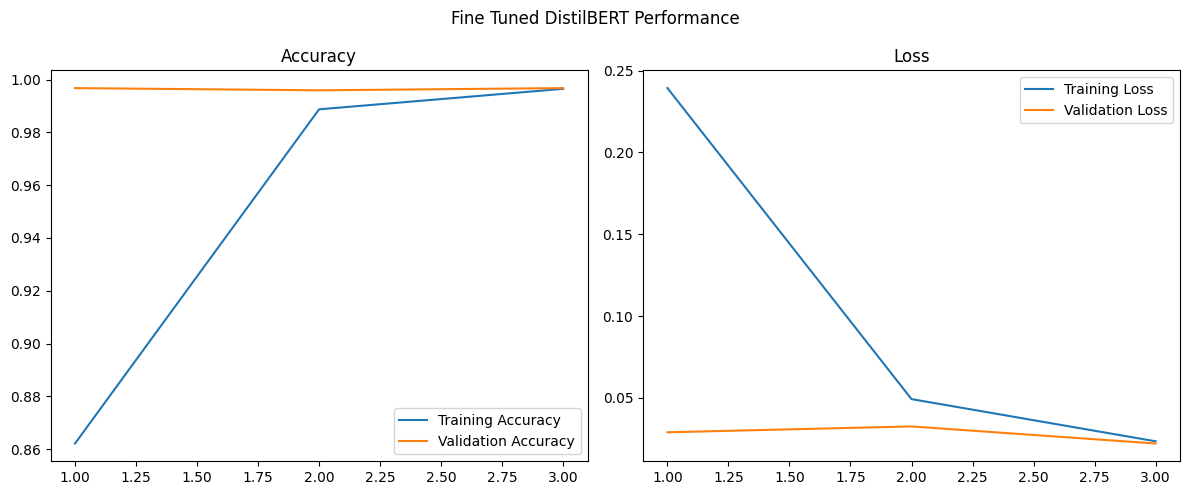

In [46]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x = [epoch + 1 for epoch in history.epoch], y = history.history["accuracy"], label = "Training Accuracy")
sns.lineplot(x = [epoch + 1 for epoch in history.epoch], y = history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
sns.lineplot(x = [epoch + 1 for epoch in history.epoch], y = history.history["loss"], label = "Training Loss")
sns.lineplot(x = [epoch + 1 for epoch in history.epoch], y = history.history["val_loss"], label = "Validation Loss")
plt.title("Loss")

plt.suptitle("Fine Tuned DistilBERT Performance")
plt.tight_layout()
plt.show()